# Final Project - Model2

**Course**: ANLY590

**Group Members**: Yuan Liu, Guiming Xu, Kuiyu Zhu, Yuxuan Yao

**NetID**: yl1130,gx26, kz175, yy560

**Dataset**: https://www.kaggle.com/cse0031/speech-representation-and-data-exploration

The dataset contains information files and a folder of audio files. The labels that we need to predict in tests are Yes, No, Up, Down, Left, Right, On, Off, Stop, Go, and everything else should be considered either unknown or silent.

### Import Packages

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot 
import random
import soundfile as sf

### Data Processing

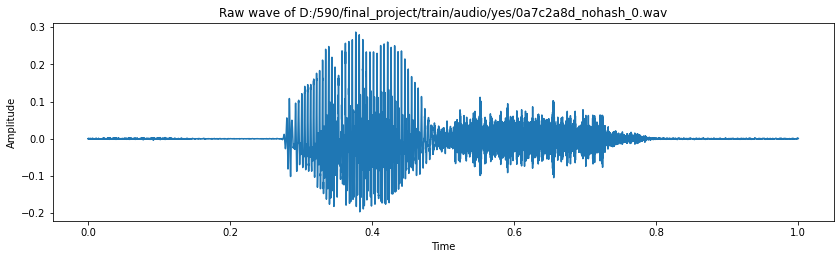

In [2]:
train_audio_path = 'D:/590/final_project/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'D:/590/final_project/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [3]:
samples

array([ 0.00042725, -0.00021362, -0.00042725, ...,  0.00057983,
        0.00061035,  0.00082397], dtype=float32)

In [4]:
sample_rate

16000

In [5]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


As we can see, the audio file is transforming to a 1D array. And the rate of sample is 16000.

In that case, we think about downsampling, which can reduce computing time.

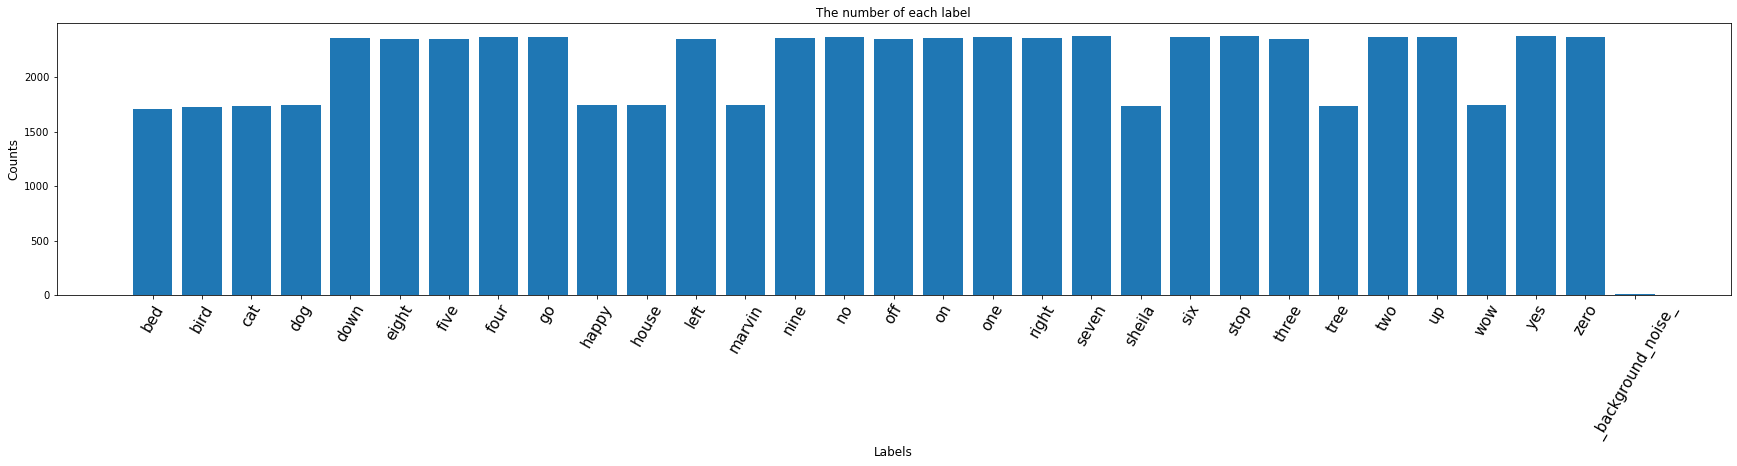

In [7]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
temp=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    temp.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, temp)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('The number of each label')
plt.show()
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "wow", "house", "happy", "tree", "dog", "cat", "bird", 
        "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

In data processing part, we know that most audio files are 1 second duration time and we plot them.

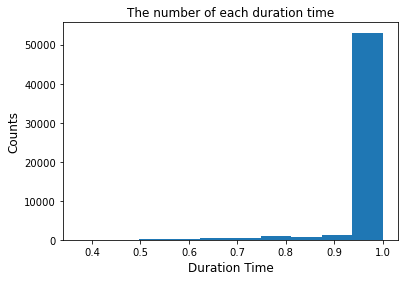

In [8]:
temp=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        temp.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(temp))
plt.xlabel('Duration Time', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('The number of each duration time')
plt.show()

Before modeling, we should downsample all audio files.

In [9]:
train_audio_path = 'D:/590/final_project/train/audio/'
audios = []
allLabel = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            audios.append(samples)
            allLabel.append(label)

yes
no
up
down
left
right
on
off
stop
go
wow
house
happy
tree
dog
cat
bird
one
two
three
four
five
six
seven
eight
nine


Encoder labels

In [10]:
le = LabelEncoder()
y=le.fit_transform(allLabel)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
audios = np.array(audios).reshape(-1,8000,1)

### Modeling

Split train and test sets

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(audios),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [55]:
x_train.shape

(41127, 8000, 1)

In [57]:
y_train.shape

(41127, 26)

In [58]:
x_val.shape

(10282, 8000, 1)

In [59]:
y_val.shape

(10282, 26)

In [77]:
from keras.layers import BatchNormalization,Activation, GlobalMaxPool1D
K.clear_session()
init_filter_num = 8
x_in_1d = Input(shape = (8000,1))
x_1d = BatchNormalization(name = 'batchnormal_1d_in')(x_in_1d)
for i in range(9):
    name = 'step'+str(i)
    x_1d = Conv1D(8*(2 ** i), (3),padding = 'same', name = 'conv'+name+'_1')(x_1d)
    x_1d = BatchNormalization(name = 'batch'+name+'_1')(x_1d)
    x_1d = Activation('relu')(x_1d)
    x_1d = Conv1D(8*(2 ** i), (3),padding = 'same', name = 'conv'+name+'_2')(x_1d)
    x_1d = BatchNormalization(name = 'batch'+name+'_2')(x_1d)
    x_1d = Activation('relu')(x_1d)
    x_1d = MaxPooling1D((2), padding='same')(x_1d)
x_1d = Conv1D(1024, (1),name='last1024')(x_1d)
x_1d = GlobalMaxPool1D()(x_1d) #only g max
x_1d = Dense(1024, activation = 'relu', name= 'dense1024_onlygmax')(x_1d)
x_1d = BatchNormalization(1)(x_1d)
x_1d = Dense(len(labels), activation = 'softmax',name='cls_1d')(x_1d)
model1 = Model(x_in_1d, x_1d)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batchnormal_1d_in (BatchNorm (None, 8000, 1)           4         
_________________________________________________________________
convstep0_1 (Conv1D)         (None, 8000, 8)           32        
_________________________________________________________________
batchstep0_1 (BatchNormaliza (None, 8000, 8)           32        
_________________________________________________________________
activation (Activation)      (None, 8000, 8)           0         
_________________________________________________________________
convstep0_2 (Conv1D)         (None, 8000, 8)           200       
_________________________________________________________________
batchstep0_2 (BatchNormaliza (None, 8000, 8)          

In [81]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model1.fit(x_train, y_train, epochs=1,validation_data=(x_val,y_val))

1286/1286 [==============================] - 3386s 3s/step - loss: 1.5068 - accuracy: 0.5447 - val_loss: 1.5781 - val_accuracy: 0.5820


In [82]:
score = model1.evaluate(x_val,y_val, verbose=1)
print("The test accuracy: {acc}".format(acc = score[1]))

322/322 [==============================] - 69s 216ms/step - loss: 1.5781 - accuracy: 0.5820
The test accuracy: 0.5819879174232483
